In [1]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta



In [2]:
x_train_scaled = pd.read_csv('../260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.468042,0.335792,0.0,0.609518,0.535456,0.0,0.543158,0.622641,0.0,1.0
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.159464,0.0,0.173529,0.018188,0.0,0.623796,0.301179,0.0,0.0
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.335173,0.241577,0.0,0.659563,0.000000,0.0,0.853118,0.431083,0.0,0.0
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.181256,0.297248,0.0,0.837676,0.480372,0.0,0.392582,0.390569,0.0,0.0
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.319013,0.306320,0.0,0.893448,0.485539,0.0,0.259900,0.431818,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,0.382762,0.384030,0.377332,0.360165,0.300915,0.340090,0.077348,0.890965,0.261140,0.205779,...,0.209212,0.301844,0.0,0.643267,0.143476,0.0,0.262892,0.189790,0.0,0.0
182_CD_plain,0.679910,0.584723,0.722426,0.643867,0.740014,0.650358,0.468650,0.295686,0.649939,0.609862,...,0.408592,0.042243,0.0,0.765285,0.527984,0.0,0.413798,0.270021,0.0,0.0
164_CD_plain,0.754656,0.556562,0.694062,0.748334,0.535534,0.133869,0.319071,0.154562,0.440487,0.824013,...,0.514164,0.364434,0.0,0.930260,0.481733,0.0,0.273699,0.433093,0.0,0.0


In [3]:
x_test_scaled = pd.read_csv('../260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.339788,0.326732,0.0,0.862246,0.074473,0.0,0.498941,0.349920,0.0,0.0
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.354602,-0.031527,0.0,0.717305,0.039214,0.0,0.697073,0.268224,0.0,0.0
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.320002,0.379134,0.0,0.604202,0.610072,0.0,0.324065,0.375123,0.0,0.0
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.445680,0.178908,0.0,0.702114,0.325357,0.0,0.390919,0.185509,0.0,0.0
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.419254,0.312215,0.0,0.821584,0.632007,0.0,0.183158,0.271359,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.379431,0.233196,0.0,0.759342,0.567491,0.0,0.404604,0.190411,0.0,0.0
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.181052,0.342262,0.0,0.639644,0.540444,0.0,0.397274,0.061934,0.0,0.0
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.331961,0.275577,0.0,0.886616,0.658049,0.0,0.259391,0.471132,0.0,0.0


In [4]:
sh = x_train_scaled.head(1).shape

In [5]:


# class AutoEncoder(Model):

#     def __init__(self, n_inputs, init_fn, n_bottleneck=32):

#         super().__init__()

#         self.encoder = Sequential(
#             [

#                 Input(shape=(n_inputs,)),
#                 # encoder level 1
#                 Dense(n_inputs*2, kernel_initializer=init_fn,
#     bias_initializer=initializers.Zeros()),
#                 BatchNormalization(),
#                 LeakyReLU(),
#                 # encoder level 2
#                 Dense(n_inputs),
#                 BatchNormalization(),
#                 LeakyReLU(),
#                 # bottleneck
#                 Dense(n_bottleneck)
#             ]
#         )



#     def call(self, inputs):

#         encoded = self.encoder(inputs)
#         return encoded

In [6]:
# n_bottleneck = 32
# initializer = tf.keras.initializers.GlorotUniform()
# auto_encoder = AutoEncoder(219,initializer, n_bottleneck)

In [7]:
# auto_encoder.encoder.load_weights("encoder_ckpt")

In [8]:
# auto_encoder.build(sh) 
# auto_encoder.summary()

In [9]:
# auto_encoder.encoder.summary()

In [10]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [11]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [12]:
n_inputs = 219
n_bottleneck = 32
encoder_base = Sequential(
            [

#                 Input(shape=(n_inputs,)),
                # encoder level 1
                Dense(n_inputs*2),
                BatchNormalization(),
                LeakyReLU(),
                # encoder level 2
                Dense(n_inputs),
                BatchNormalization(),
                LeakyReLU(),
                # bottleneck
                Dense(n_bottleneck)
            ]
        )

In [13]:
encoder_base.load_weights("../encoder_ckpt")

In [14]:
# encoder_base.trainable = False
encoder_base.build(sh) 
encoder_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 438)                  96360     
                                                                 
 batch_normalization (BatchN  (1, 438)                 1752      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (1, 438)                  0         
                                                                 
 dense_1 (Dense)             (1, 219)                  96141     
                                                                 
 batch_normalization_1 (Batc  (1, 219)                 876       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (1, 219)                  0

In [15]:
x_train_scaled.shape

(182, 219)

In [16]:
# inputs = keras.Input(shape=(219,))
# x = encoder_base(inputs, training=False)
inter = Dense(24, activation='relu')

In [17]:
# inter = Dense(24, activation='relu')(x)
# outputs = Dense(3, activation='softmax')(inter)
# compound_model = Model(inputs, outputs)

compound_model = encoder_base
compound_model.add(Dense(24, activation='relu'))
compound_model.add(Dense(3, activation='softmax'))

In [18]:
x_train_scaled.head(1).values.flatten().shape

(219,)

In [19]:
y = compound_model(x_train_scaled.head(1).values)

In [20]:
compound_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 438)                  96360     
                                                                 
 batch_normalization (BatchN  (1, 438)                 1752      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (1, 438)                  0         
                                                                 
 dense_1 (Dense)             (1, 219)                  96141     
                                                                 
 batch_normalization_1 (Batc  (1, 219)                 876       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (1, 219)                  0

In [21]:
for i in range(7):
    compound_model.layers[i].trainable = False

compound_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 438)                  96360     
                                                                 
 batch_normalization (BatchN  (1, 438)                 1752      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (1, 438)                  0         
                                                                 
 dense_1 (Dense)             (1, 219)                  96141     
                                                                 
 batch_normalization_1 (Batc  (1, 219)                 876       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (1, 219)                  0

In [22]:


opt = Adam(learning_rate=0.001)

compound_model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [23]:
history = compound_model.fit(x_train_scaled, disease_labels_train, epochs=100)

Epoch 1/100
6/6 [==============================] - 0s 2ms/step - loss: 1.3181 - accuracy: 0.3626
Epoch 2/100
6/6 [==============================] - 0s 1ms/step - loss: 1.1589 - accuracy: 0.3626
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 1.0850 - accuracy: 0.3626
Epoch 4/100
6/6 [==============================] - 0s 1ms/step - loss: 1.0208 - accuracy: 0.3736
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 0.9665 - accuracy: 0.4286
Epoch 6/100
6/6 [==============================] - 0s 1ms/step - loss: 0.9343 - accuracy: 0.4341
Epoch 7/100
6/6 [==============================] - 0s 1ms/step - loss: 0.8992 - accuracy: 0.4615
Epoch 8/100
6/6 [==============================] - 0s 1ms/step - loss: 0.8744 - accuracy: 0.5000
Epoch 9/100
6/6 [==============================] - 0s 1ms/step - loss: 0.8577 - accuracy: 0.5440
Epoch 10/100
6/6 [==============================] - 0s 1ms/step - loss: 0.8378 - accuracy: 0.5330
Epoch 11/100
6/6 [===========

6/6 [==============================] - 0s 1ms/step - loss: 0.5867 - accuracy: 0.7692
Epoch 85/100
6/6 [==============================] - 0s 1ms/step - loss: 0.5817 - accuracy: 0.7747
Epoch 86/100
6/6 [==============================] - 0s 1ms/step - loss: 0.5877 - accuracy: 0.7802
Epoch 87/100
6/6 [==============================] - 0s 1ms/step - loss: 0.5792 - accuracy: 0.7747
Epoch 88/100
6/6 [==============================] - 0s 1ms/step - loss: 0.5781 - accuracy: 0.7637
Epoch 89/100
6/6 [==============================] - 0s 1ms/step - loss: 0.5757 - accuracy: 0.7747
Epoch 90/100
6/6 [==============================] - 0s 1ms/step - loss: 0.5731 - accuracy: 0.7747
Epoch 91/100
6/6 [==============================] - 0s 1ms/step - loss: 0.5746 - accuracy: 0.7747
Epoch 92/100
6/6 [==============================] - 0s 1ms/step - loss: 0.5711 - accuracy: 0.7747
Epoch 93/100
6/6 [==============================] - 0s 1ms/step - loss: 0.5698 - accuracy: 0.7747
Epoch 94/100
6/6 [===============

In [24]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


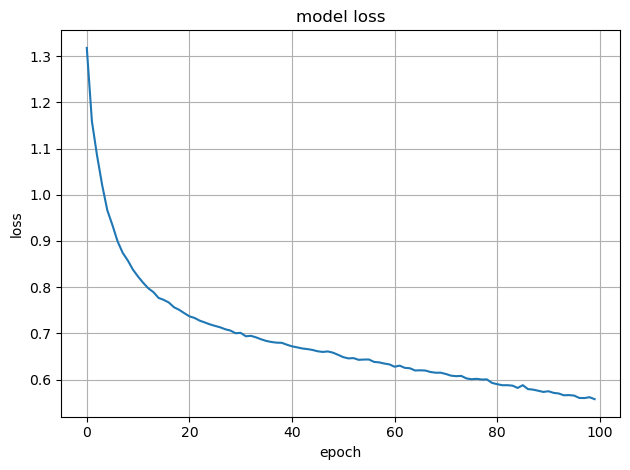

In [25]:
# summarize history for loss
plt.figure()
plt.grid()
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['Training', 'Validation'], loc='upper left')
plt.tight_layout()
# plt.savefig('autoencoder_learning_curve_loss.png', dpi=300)
plt.show()

In [26]:
test_loss, test_acc = compound_model.evaluate(x_test_scaled, disease_labels_test, verbose=2)

print('\nTest accuracy:', test_acc)

3/3 - 0s - loss: 0.8141 - accuracy: 0.6282 - 122ms/epoch - 41ms/step

Test accuracy: 0.6282051205635071


In [27]:
compound_model.predict(x_test_scaled.head(1))[0]

1/1 [==============================] - 0s 129ms/step


array([0.4530498 , 0.5262371 , 0.02071318], dtype=float32)

In [28]:
x_test_scaled.iloc[[0],:]

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.84188,0.930171,0.886737,0.835678,0.297964,0.668498,0.26667,0.278122,0.93352,...,0.339788,0.326732,0.0,0.862246,0.074473,0.0,0.498941,0.34992,0.0,0.0


## SHAP evaluation

In [29]:
# import shap

In [30]:
# explainer = shap.KernelExplainer(model=compound_model.predict, data=x_train_scaled, link="logit")

In [31]:
import sys
sys.path.insert(0,r"C:\Users\shard\OneDrive - University of Cambridge\MPhil-Sonny\research project\exploring dataset\gene_shap_minimal")

In [32]:

# sys.path

In [33]:
import objects

In [34]:
# x_train_scaled.max()

In [53]:
explainer = objects.get_explainer(model=compound_model.predict, data=x_train_scaled, link="logit")

getting explainer
6/6 [==============================] - 0s 1ms/step


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [36]:
# type(explainer)

In [37]:
# import geneSHAP

In [38]:
# explainer = shap.KernelExplainer(model=compound_model.predict, data=x_train_scaled, link="logit")

In [39]:
# x_test_scaled[:2]

In [40]:
# x_test_scaled.shape[1]

## Calculate SHAP values

In [41]:
# shap_values[0].shape

In [42]:
# shap_values = explainer.shap_values(X=x_test_scaled[:2])

In [43]:
# shap_values

## Save SHAP values

In [44]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [45]:


with open("../shap_values", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [46]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (78, 219)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

## Patient-specific plots

In [47]:
idx = 11
patient = x_test_scaled.iloc[[idx],:]
patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
58_CD_plain,0.712765,0.67885,0.86582,0.855696,0.828452,0.498697,0.567772,0.352862,0.317254,0.76505,...,0.211571,0.283032,0.0,0.703328,0.556984,0.0,0.415272,0.225017,0.0,0.0


In [48]:
x_test_scaled.iloc[[0],:]

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.84188,0.930171,0.886737,0.835678,0.297964,0.668498,0.26667,0.278122,0.93352,...,0.339788,0.326732,0.0,0.862246,0.074473,0.0,0.498941,0.34992,0.0,0.0


In [49]:
print(f'Prediction probabilities for patient: {compound_model.predict(patient)[0]}')
print("Predicted class:")

1/1 [==============================] - 0s 10ms/step
Prediction probabilities for patient: [0.02525347 0.60428613 0.3704604 ]
Predicted class:


#### Control

In [50]:
explainer

In [51]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], patient, link="logit")

NameError: name 'shap' is not defined

####  CD no ulcer

In [ ]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], patient, link="logit")

####  CD deep ulcer

In [ ]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][idx,:], patient, link="logit")

In [ ]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 11
explanation = objects.get_explanation(values=shap_values[2][idx], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

In [ ]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

#### Control

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], x_test_scaled)

####  CD no ulcer

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], x_test_scaled)

####  CD deep ulcer

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2], x_test_scaled)

## SHAP Summary Plots

In [ ]:
shap.summary_plot(shap_values, x_test_scaled)

In [ ]:
# control
shap.summary_plot(shap_values[0], x_test_scaled)

In [ ]:
# CD no ulcer
shap.summary_plot(shap_values[1], x_test_scaled)

In [ ]:
# CD deep ulcer
shap.summary_plot(shap_values[2], x_test_scaled)

## SHAP Dependence Plots

In [ ]:
# control
shap.dependence_plot("CNTFR", shap_values[0], x_test_scaled)

In [ ]:
# CD no ulcer
shap.dependence_plot("MMP1", shap_values[1], x_test_scaled)

In [ ]:
# CD deep ulcer
shap.dependence_plot("FPR2",shap_values[2], x_test_scaled)

## Clustering

In [ ]:
disease_labels_test.shape

In [ ]:
# sys.stdout = open(1, 'w')
import sys
stdout = sys.stdout
sys.stdout = sys.__stdout__

In [52]:
clustering = objects.get_clustering(x_test_scaled, disease_labels_test)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
 63%|██████████████████████████████████████████████████▍                             | 138/219 [01:07<00:27,  2.93it/s]No/low signal found from feature 137 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 138 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 139 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 140 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).


100%|███████████████████████████████████████████████████████████████████████████████▋| 218/219 [01:32<00:00,  2.49it/s]No/low signal found from feature 217 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 218 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
220it [01:32,  2.16it/s]                                                                                               


AttributeError: module 'scipy' has no attribute 'cluster'

In [68]:
clustering

array([[1.70000000e+01, 1.17000000e+02, 2.78658496e-04, 2.00000000e+00],
       [2.70000000e+01, 1.03000000e+02, 1.60029985e-03, 2.00000000e+00],
       [7.30000000e+01, 9.70000000e+01, 2.37035938e-02, 2.00000000e+00],
       [9.40000000e+01, 1.51000000e+02, 2.59982981e-02, 2.00000000e+00],
       [1.30000000e+01, 1.40000000e+01, 3.11244875e-02, 2.00000000e+00],
       [1.80000000e+01, 1.90000000e+01, 3.62407155e-02, 2.00000000e+00],
       [1.60000000e+01, 2.19000000e+02, 4.06356938e-02, 3.00000000e+00],
       [6.90000000e+01, 1.44000000e+02, 4.48985957e-02, 2.00000000e+00],
       [6.00000000e+01, 1.85000000e+02, 4.80836630e-02, 2.00000000e+00],
       [1.11000000e+02, 2.21000000e+02, 5.25651686e-02, 3.00000000e+00],
       [4.70000000e+01, 2.22000000e+02, 5.38369715e-02, 3.00000000e+00],
       [8.40000000e+01, 2.28000000e+02, 5.78508116e-02, 4.00000000e+00],
       [0.00000000e+00, 2.20000000e+02, 6.06672280e-02, 3.00000000e+00],
       [8.20000000e+01, 1.05000000e+02, 6.17962405e

In [85]:
clustering.shape

(218, 4)

In [77]:
x_test_scaled.iloc[70]

AADAC           0.631350
APOA1           0.589925
APOA4           0.672493
APOB            0.684450
APOC3           0.603240
                  ...   
RSL24D1P1       0.000000
MIEN1           0.331986
PCBP1_AS1       0.340875
LOC100133165    0.000000
DNAJB8          0.000000
Name: 165_CD_deep_ulcer, Length: 219, dtype: float64

In [88]:
len(shap_values) # 3 classes

3

In [87]:
shap_values[0].shape # all patients control

(78, 219)

In [113]:
shap_values

[array([[-0.01699713, -0.02122785, -0.07081215, ...,  0.01084949,
          0.        ,  0.00051126],
        [-0.03504436, -0.01809754, -0.0933113 , ..., -0.01480058,
          0.        ,  0.        ],
        [-0.01922192, -0.0295569 ,  0.12407631, ..., -0.04045843,
          0.        ,  0.08289485],
        ...,
        [ 0.00284362, -0.00274887, -0.03769537, ..., -0.02929007,
          0.        ,  0.01550877],
        [ 0.0288744 , -0.00817472,  0.04456285, ...,  0.02605667,
          0.        , -0.01137171],
        [ 0.01534977,  0.0051884 ,  0.03308644, ...,  0.        ,
          0.        , -0.00724134]]),
 array([[ 0.01316442,  0.08507023,  0.04762821, ...,  0.00550245,
          0.        ,  0.02279419],
        [-0.00484329,  0.14786945,  0.05410845, ...,  0.01534487,
          0.        ,  0.00955716],
        [-0.03004311, -0.1381944 ,  0.0113248 , ...,  0.01228212,
          0.        , -0.01099716],
        ...,
        [ 0.        ,  0.04527464,  0.01814485, ...,  

In [78]:
row = 70
exp = shap.Explanation(values=shap_values[2][row], base_values=explainer.expected_value[2], 
                                data=x_test_scaled.iloc[row], feature_names=x_test_scaled.columns.tolist())

# patient 8: explanations for CD deep ulcer diagnosis

In [ ]:
type(exp)

In [ ]:
# with open("clust", "wb") as fp:   #Pickling
#     pickle.dump(clustering, fp)

In [57]:

with open("../clust", "rb") as fp:   # Unpickling
    clustering = pickle.load(fp)

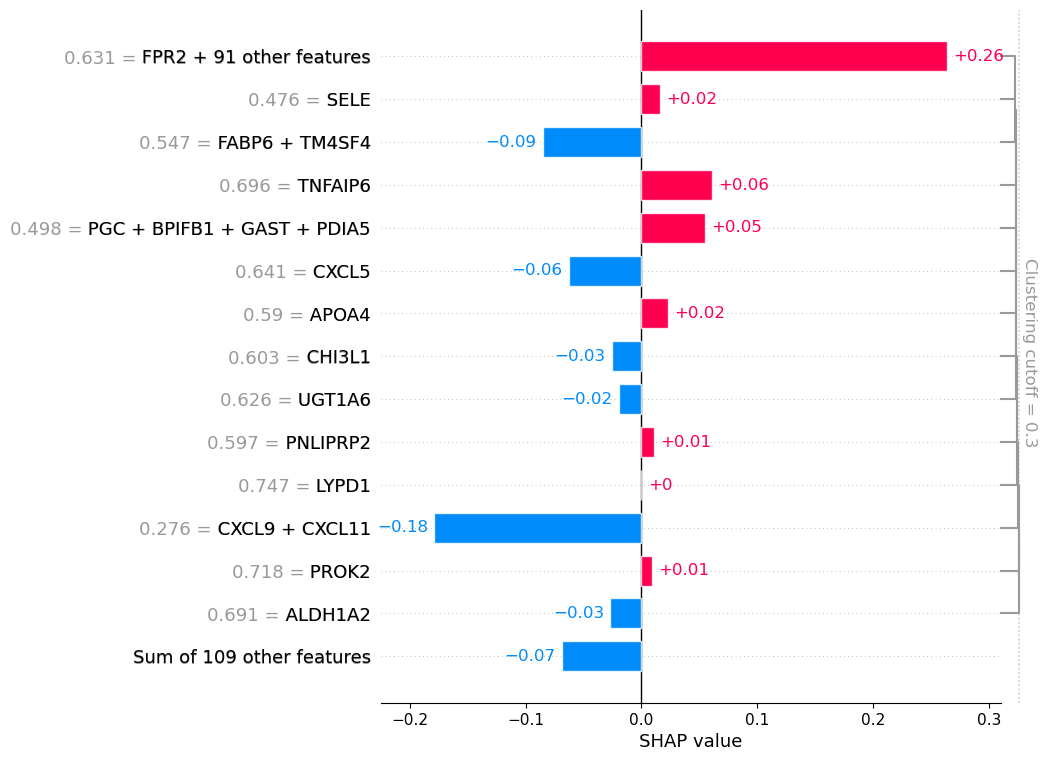

In [84]:
import shap
# shap.plots.bar(explanation, clustering=clustering)
shap.plots.bar(exp, max_display=15, clustering_cutoff=0.3,
               clustering=clustering)

In [90]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster

In [97]:
fcluster(clustering, .2, criterion='distance')

array([ 21,  21,  35,  21,  21,  21,  45,  70,  36,  21,  27,  44,  22,
        21,  21,  16,  21,  21,  21,  21,  21,  21,   7,  21,  21,  21,
        21,  21,  21,  29,   8,  21,  30,  25,  21,  50,  21,  20,  88,
        21,  13,  21,  21,  21,  21,   9,  21,  15,  38,  21,  21,  18,
        21,  21,  14,  34,  32,  21,  21,  21,  21,  21,  21,  10,  17,
        33,  21,  21,  21,  21,  21,  18,  41,  21,  21,  47,  21,  21,
        27,  26,  31,  24,  21,  20,  21,  18,  37,  21,  11,  40,  21,
        28,  21,  21,  15,  39,  21,  21,  21,  21,  21,  18,   7,  21,
        74,  21,  12,  66,  21,  21,  19,  21,  21,  46,  21,  20,  89,
        21,  21,  51,  94,  64,  95,   5,  60,  96,  53,  54,  55,  84,
        83,  93,  42,  97,  21,  98,  21,  99, 100, 101, 102, 103, 104,
        56,  21, 105, 106,   6,  48, 107,  62,  15, 108,  92,  91,  23,
        86,   3,  72,  68,  81, 109,  52, 110, 111, 112,  53,  87,  15,
         1,  90, 113,  71, 114, 115, 116,  76,  21, 117,   2, 11

{'icoord': [[615.0, 615.0, 625.0, 625.0],
  [635.0, 635.0, 645.0, 645.0],
  [755.0, 755.0, 765.0, 765.0],
  [815.0, 815.0, 825.0, 825.0],
  [805.0, 805.0, 820.0, 820.0],
  [895.0, 895.0, 905.0, 905.0],
  [925.0, 925.0, 935.0, 935.0],
  [965.0, 965.0, 975.0, 975.0],
  [1065.0, 1065.0, 1075.0, 1075.0],
  [1055.0, 1055.0, 1070.0, 1070.0],
  [1045.0, 1045.0, 1062.5, 1062.5],
  [1095.0, 1095.0, 1105.0, 1105.0],
  [1155.0, 1155.0, 1165.0, 1165.0],
  [1145.0, 1145.0, 1160.0, 1160.0],
  [1135.0, 1135.0, 1152.5, 1152.5],
  [1125.0, 1125.0, 1143.75, 1143.75],
  [1185.0, 1185.0, 1195.0, 1195.0],
  [1175.0, 1175.0, 1190.0, 1190.0],
  [1365.0, 1365.0, 1375.0, 1375.0],
  [1355.0, 1355.0, 1370.0, 1370.0],
  [1385.0, 1385.0, 1395.0, 1395.0],
  [1405.0, 1405.0, 1415.0, 1415.0],
  [1435.0, 1435.0, 1445.0, 1445.0],
  [1525.0, 1525.0, 1535.0, 1535.0],
  [1515.0, 1515.0, 1530.0, 1530.0],
  [1505.0, 1505.0, 1522.5, 1522.5],
  [1555.0, 1555.0, 1565.0, 1565.0],
  [1545.0, 1545.0, 1560.0, 1560.0],
  [1615.0, 1

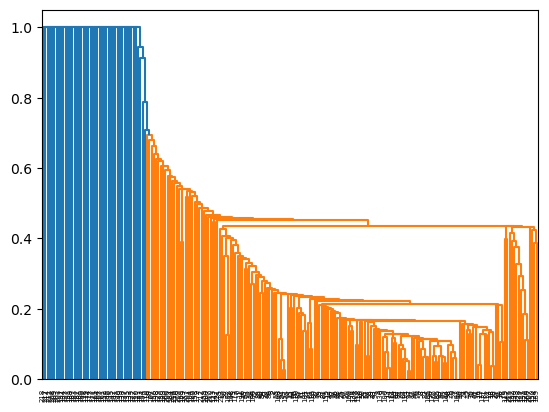

In [71]:
dendrogram(clustering, show_leaf_counts=False)

In [102]:
import seaborn as sns

In [107]:
patient_shap_cd_deep = shap_values[2][row]
patient_shap_cd_deep.shape

(219,)

## Hierarchical clustering of genes based on shap values, across all patients with given disease classification

In [130]:


all_gene_df = pd.DataFrame(shap_values[2], index=x_test_scaled.index, columns = x_test_scaled.columns)
df_cd_deep = all_gene_df[all_gene_df.index.str.endswith('_CD_deep_ulcer')]
df_cd_plain = all_gene_df[all_gene_df.index.str.endswith('_CD_plain')]
df_control = all_gene_df[all_gene_df.index.str.endswith('_control')]
df_cd_deep

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
62_CD_deep_ulcer,-0.003603,0.105250,-0.047044,-0.014947,0.000000,0.187628,0.044242,-0.022843,-0.039989,-0.027093,...,0.005510,0.020320,0.0,0.005488,0.093866,0.0,-0.022522,0.017015,0.0,-0.005428
167_CD_deep_ulcer,0.000000,0.126500,-0.008472,-0.008706,0.006454,0.038979,0.077657,-0.009717,0.004276,-0.044046,...,0.000000,0.014907,0.0,-0.010542,0.000000,0.0,0.011755,0.015677,0.0,0.003833
196_CD_deep_ulcer,-0.015137,0.107726,-0.019753,-0.035331,-0.005677,0.071594,0.085403,-0.028361,-0.003345,-0.070816,...,0.006771,0.011001,0.0,-0.010174,0.053967,0.0,-0.006063,0.019399,0.0,0.000000
23_CD_deep_ulcer,-0.008684,0.120806,0.010906,0.010129,0.008627,0.021136,0.103641,-0.014707,-0.043298,-0.013828,...,-0.002069,-0.007453,0.0,-0.004402,-0.007919,0.0,-0.038069,-0.007942,0.0,0.000229
93_CD_deep_ulcer,-0.012503,0.072120,0.015956,0.025606,0.023989,-0.010768,0.062960,-0.015463,-0.005831,-0.006509,...,0.000000,0.011604,0.0,0.009995,-0.009878,0.0,-0.046551,-0.013389,0.0,0.007504
229_CD_deep_ulcer,0.001986,-0.029862,0.033261,0.012434,0.004867,0.043208,0.135541,-0.023186,-0.031205,0.000694,...,-0.004143,-0.003321,0.0,-0.016468,0.000000,0.0,-0.005444,-0.004833,0.0,-0.003707
46_CD_deep_ulcer,-0.018424,0.047551,-0.018109,-0.022701,0.022517,0.073889,0.000000,-0.003175,-0.079742,-0.048241,...,-0.010020,0.006414,0.0,-0.021528,-0.015837,0.0,-0.047300,0.073698,0.0,-0.003912
176_CD_deep_ulcer,-0.008224,-0.041478,0.008979,0.003781,0.006723,-0.004739,0.028163,-0.021048,0.000000,0.017253,...,-0.018132,0.013266,0.0,-0.006989,-0.021579,0.0,0.029404,0.019017,0.0,-0.006064
49_CD_deep_ulcer,0.031895,0.041962,-0.021250,-0.009139,0.014773,-0.114689,-0.004494,0.089633,-0.024799,-0.078440,...,0.000000,0.005732,0.0,-0.013694,0.023908,0.0,-0.010416,0.000000,0.0,-0.028094


In [150]:
from scipy.cluster.hierarchy import dendrogram, linkage

### Example: CD deep ulcer patients

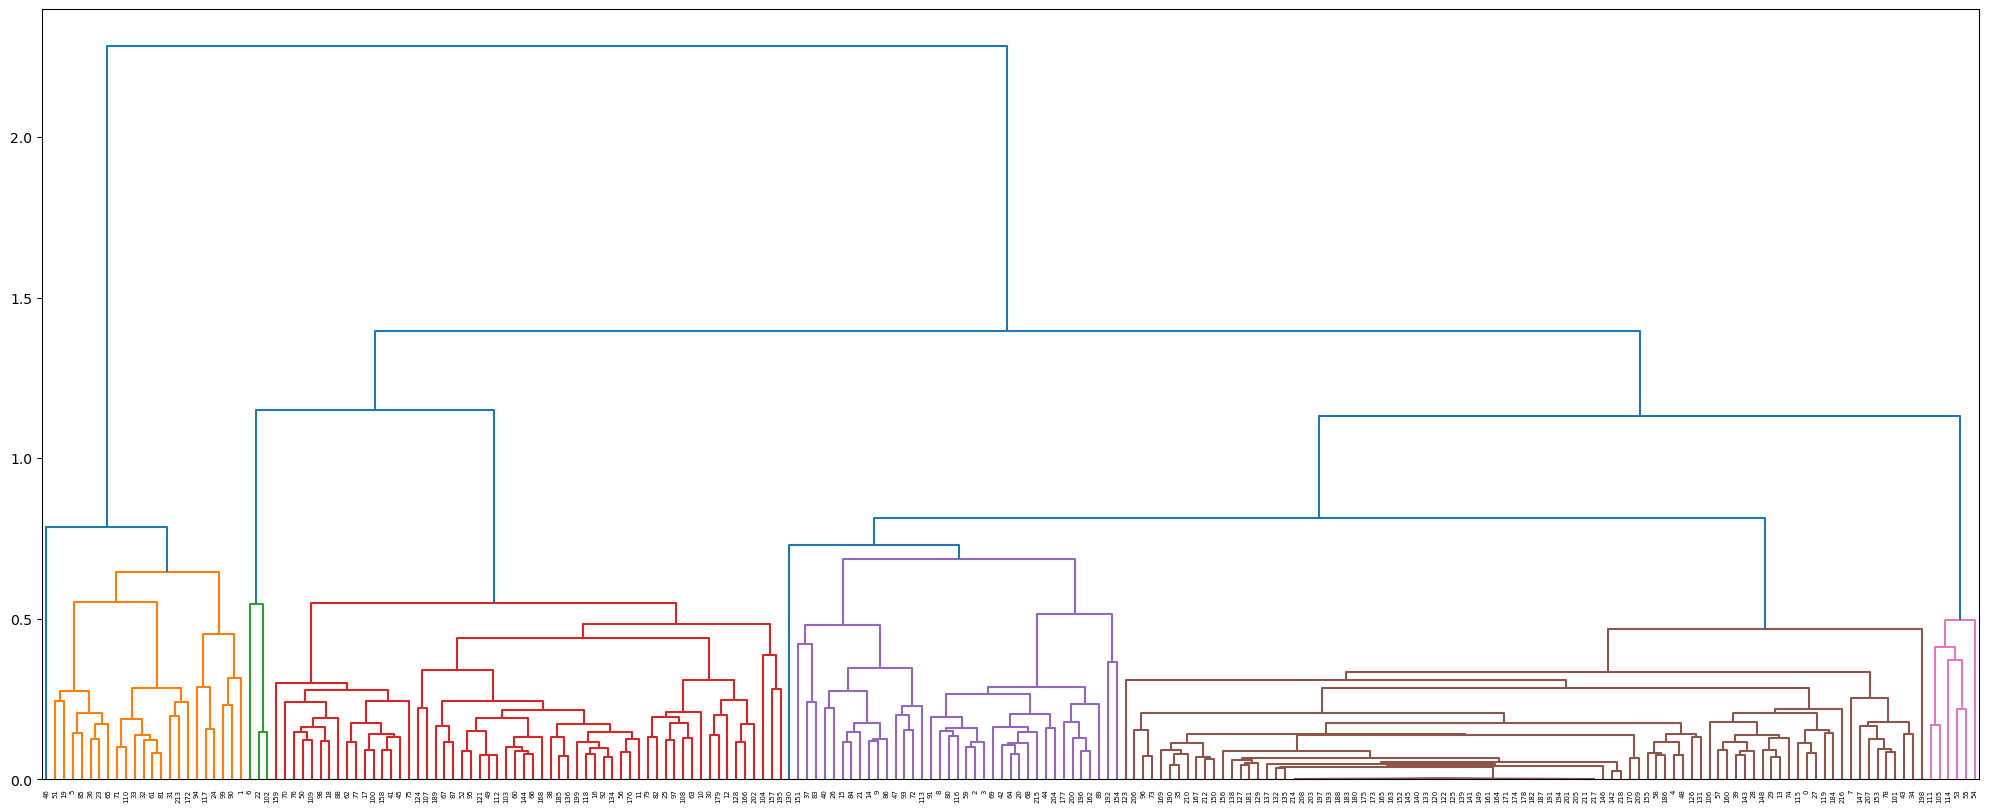

In [367]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_deep = linkage(df_cd_deep.T, 'ward', metric='euclidean', optimal_ordering=True)
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = .7)
# plt.axhline(y=.7, c='r')

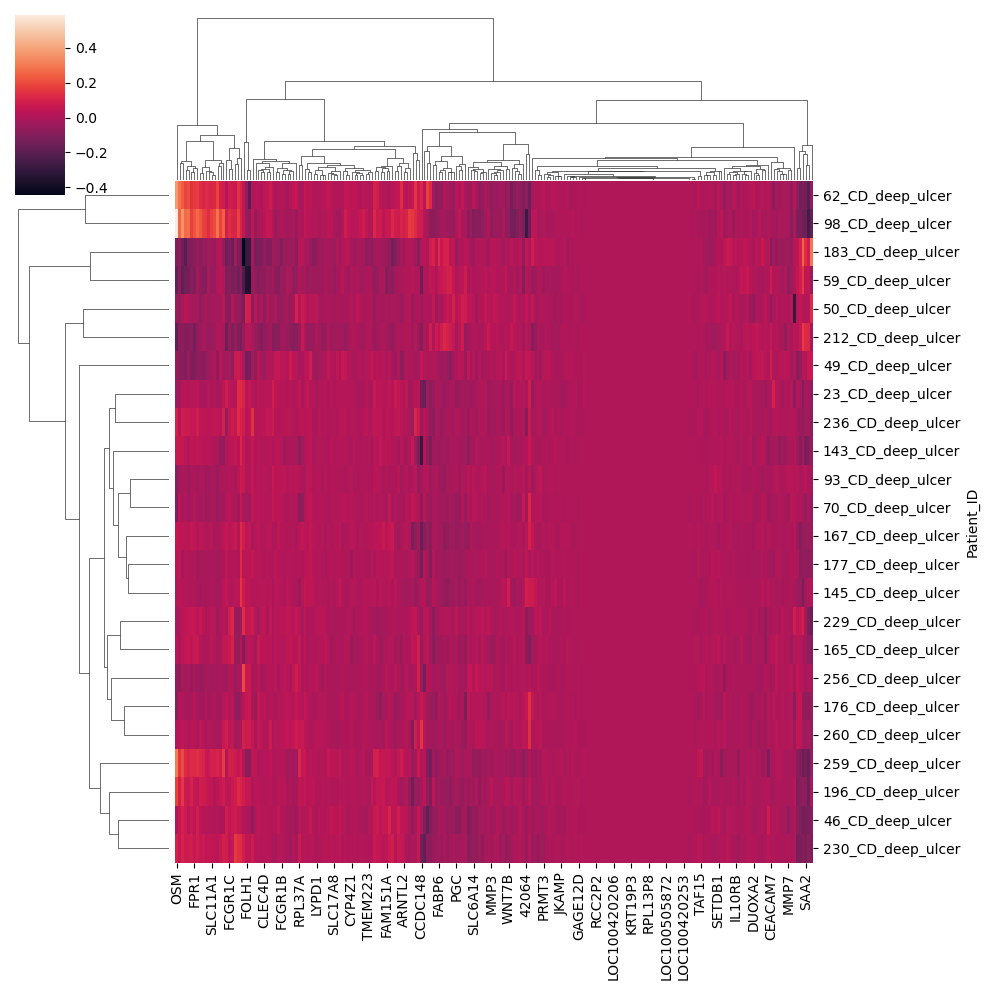

In [368]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_deep, col_linkage=gene_cluster_cd_deep)

## Aggregate bar plot, showing possible gene modules alongside SHAP contributions

In [214]:
gene_cluster_cd_deep

array([[1.20000000e+02, 1.22000000e+02, 0.00000000e+00, 2.00000000e+00],
       [2.19000000e+02, 1.25000000e+02, 0.00000000e+00, 3.00000000e+00],
       [1.33000000e+02, 2.20000000e+02, 0.00000000e+00, 4.00000000e+00],
       [2.21000000e+02, 1.39000000e+02, 0.00000000e+00, 5.00000000e+00],
       [1.40000000e+02, 2.22000000e+02, 0.00000000e+00, 6.00000000e+00],
       [2.23000000e+02, 1.41000000e+02, 0.00000000e+00, 7.00000000e+00],
       [1.45000000e+02, 2.24000000e+02, 0.00000000e+00, 8.00000000e+00],
       [2.25000000e+02, 1.49000000e+02, 0.00000000e+00, 9.00000000e+00],
       [1.52000000e+02, 2.26000000e+02, 0.00000000e+00, 1.00000000e+01],
       [2.27000000e+02, 1.61000000e+02, 0.00000000e+00, 1.10000000e+01],
       [1.63000000e+02, 2.28000000e+02, 0.00000000e+00, 1.20000000e+01],
       [2.29000000e+02, 1.64000000e+02, 0.00000000e+00, 1.30000000e+01],
       [1.65000000e+02, 2.30000000e+02, 0.00000000e+00, 1.40000000e+01],
       [2.31000000e+02, 1.71000000e+02, 0.00000000e

In [330]:
cluster_labels = fcluster(gene_cluster_cd_deep, .7, criterion='distance')
cluster_labels.shape

(219,)

In [331]:
cluster_labels

array([7, 1, 5, 5, 7, 1, 3, 7, 5, 5, 4, 4, 4, 7, 5, 5, 4, 4, 4, 1, 5, 5,
       3, 1, 1, 4, 5, 7, 7, 7, 4, 1, 1, 1, 7, 7, 1, 5, 4, 7, 5, 4, 5, 7,
       5, 4, 2, 5, 7, 4, 4, 1, 4, 8, 8, 8, 4, 7, 7, 5, 4, 1, 4, 4, 5, 1,
       4, 4, 5, 5, 4, 1, 5, 7, 7, 4, 4, 4, 7, 4, 5, 1, 4, 5, 5, 1, 5, 4,
       4, 5, 1, 5, 4, 5, 1, 4, 7, 4, 4, 1, 4, 7, 3, 4, 4, 8, 7, 4, 4, 4,
       1, 8, 4, 5, 8, 7, 5, 1, 4, 7, 7, 4, 7, 7, 4, 7, 7, 7, 4, 7, 6, 7,
       7, 7, 4, 7, 4, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 5, 7, 7,
       5, 7, 7, 4, 4, 4, 7, 7, 5, 7, 7, 7, 4, 7, 4, 7, 7, 7, 1, 7, 7, 7,
       4, 5, 7, 4, 7, 7, 7, 7, 7, 4, 7, 7, 7, 4, 7, 7, 5, 7, 7, 4, 5, 7,
       7, 4, 5, 7, 4, 7, 5, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 5, 7, 7, 7],
      dtype=int32)

In [332]:
stats = df_cd_deep.describe().T.sort_values("mean")
mean_df = pd.DataFrame(stats.iloc[:,1])
mean_df

,mean
CXCL5,-0.052544
CCDC148,-0.041960
SAA2,-0.040650
DUOX2,-0.036466
CXCL11,-0.031009
...,...
TNFAIP6,0.026425
SNORD89,0.033660
OSM,0.035662
FCGR3B,0.037420


In [333]:
mean_df["group_num"] = cluster_labels
mean_df["gene_symbol"] = mean_df.index
mean_df

,mean,group_num,gene_symbol
CXCL5,-0.052544,7,CXCL5
CCDC148,-0.041960,1,CCDC148
SAA2,-0.040650,5,SAA2
DUOX2,-0.036466,5,DUOX2
CXCL11,-0.031009,7,CXCL11
...,...,...,...
TNFAIP6,0.026425,7,TNFAIP6
SNORD89,0.033660,5,SNORD89
OSM,0.035662,7,OSM
FCGR3B,0.037420,7,FCGR3B


In [359]:
def group_labels(x):
    if len(x) > 5:
        gene_list = x[:5]
    else:
        gene_list = x
    return ", ".join(gene_list)

def add_other(num, curr_label):
#     print(type(num))
#     print(type(curr_label))
    if num > 1:
        other = " others" if num > 2 else " other"
        return curr_label + " + " + str(num) + other
    else:
        return curr_label
    
def test(x, y):
    return 0


In [360]:
# agg_df = mean_df.groupby(['cluster_labels']).agg([group_labels, 'sum', 'count'])
# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', list))

def group_fn(data):
    d = {}
    mean_vals = data['mean']
    symbols = list(data['gene_symbol'])
#     print(symbols)
    mean_dict = {symbols[i]: mean_vals[i] for i in range(len(symbols))}
#     print(mean_dict)
    gene_dict = dict(sorted(mean_dict.items(), key=lambda x : x[1], reverse=True))
    gene_list = list(gene_dict.keys())
#     print(gene_list)
    d['sum'] = np.sum(data['mean'])
    d['gene_count'] = data['mean'].count()
    d['grouped_genes'] = gene_list
    return pd.Series(d)

agg_df = mean_df.groupby(['group_num']).apply(group_fn)
# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,-0.140106,22,"[PPP2R5B, VPS26B, LOC100505872, LOC100128493, ...","PPP2R5B, VPS26B, LOC100505872, LOC100128493, U..."
2,-0.008284,1,[RTN1],RTN1
3,-0.040942,3,"[LOC100133147, PGC, CXCL3]","LOC100133147, PGC, CXCL3 + 3 others"
4,-0.104614,58,"[FCGR1C, SLC5A12, FCGR3A, CLEC5A, G6PC, IL1RN,...","FCGR1C, SLC5A12, FCGR3A, CLEC5A, G6PC + 58 others"
5,-0.148811,37,"[SNORD89, LRRC43, RUFY4, RPL37A, CUBN, SETDB1,...","SNORD89, LRRC43, RUFY4, RPL37A, CUBN + 37 others"
6,0.000510,1,[LYPD1],LYPD1
7,0.402811,91,"[APOA1, FCGR3B, OSM, TNFAIP6, S100A12, FPR2, S...","APOA1, FCGR3B, OSM, TNFAIP6, S100A12 + 91 others"
8,-0.017536,6,"[IGKV2D_28, RCC2P2, LOC100130566, PSME1, JKAMP...","IGKV2D_28, RCC2P2, LOC100130566, PSME1, JKAMP ..."


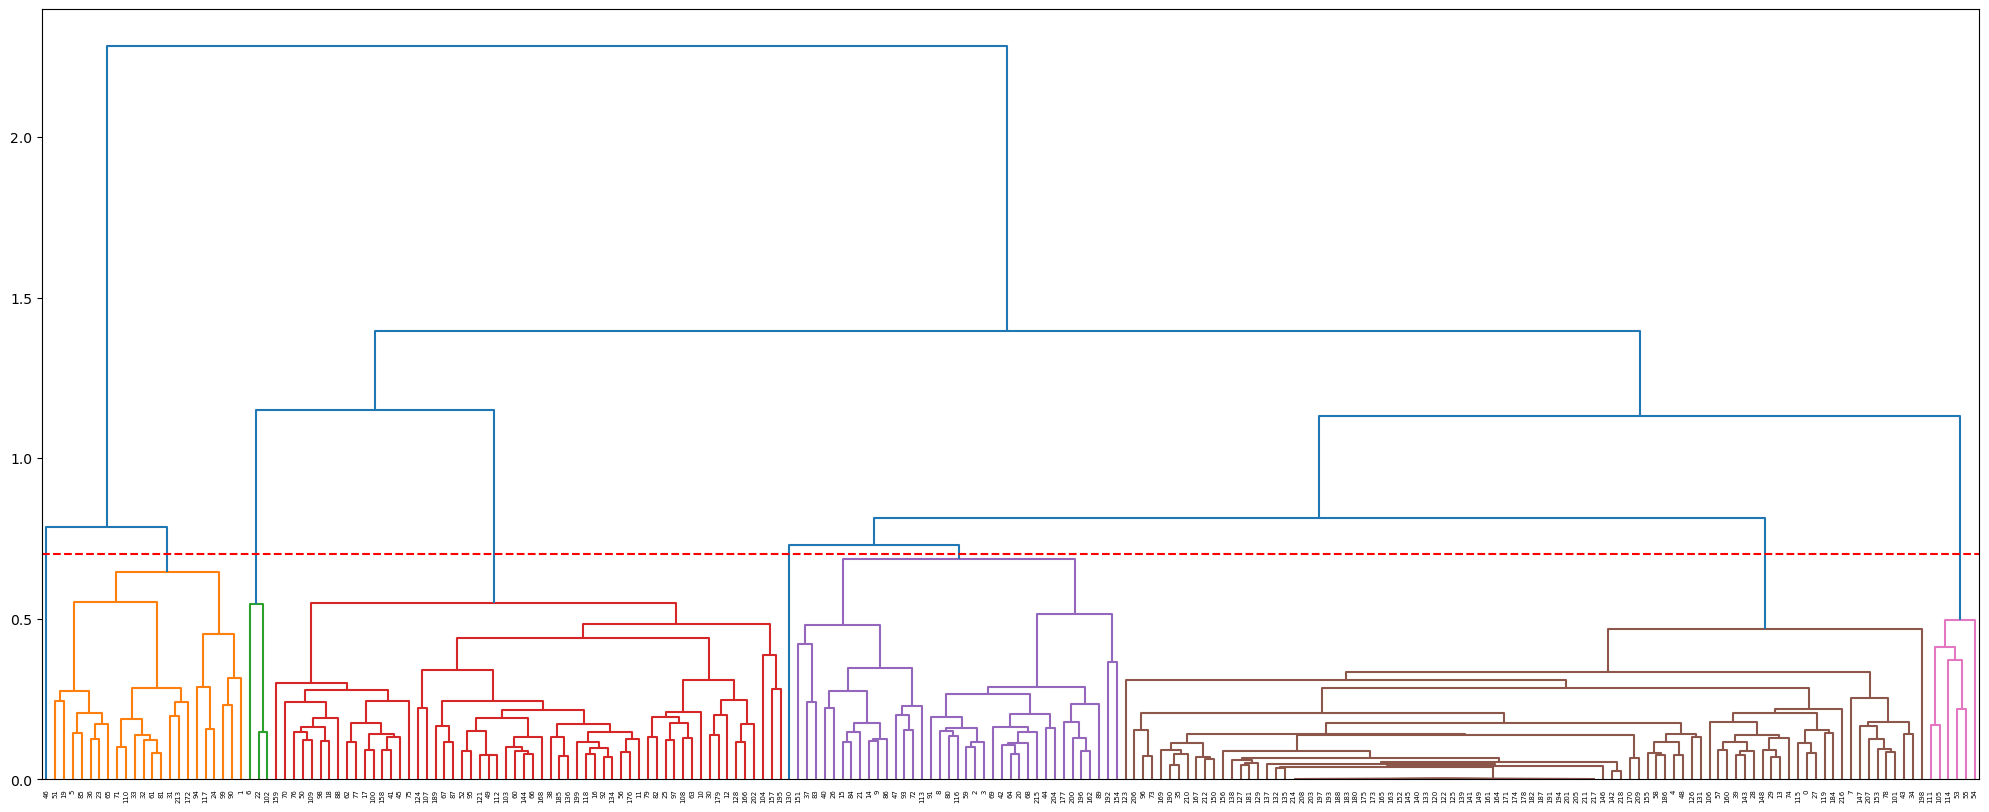

In [369]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = 0.7)
plt.axhline(y=.7, c='r', linestyle='--')

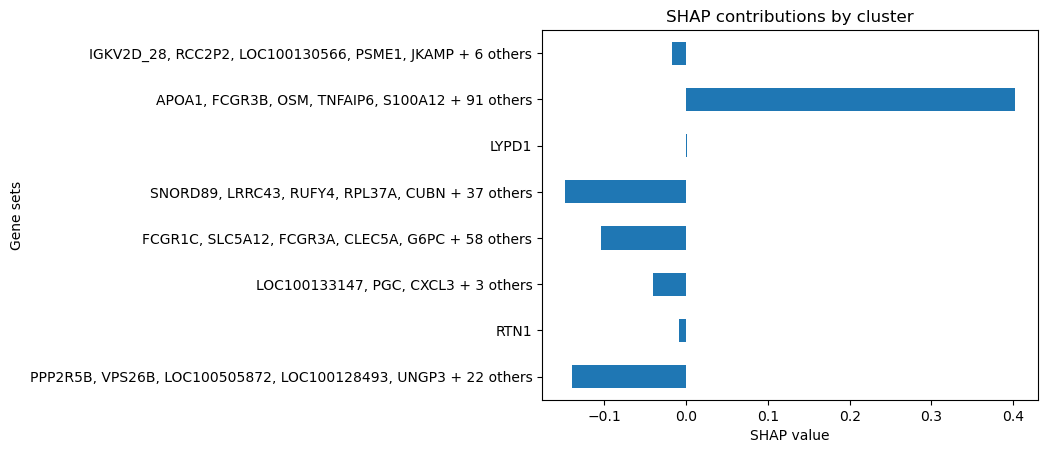

In [370]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None)
plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value')
# plt.legend.remove()
plt.show()

gene names shown in sorted order
can get full lists from dataframe

In [358]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")

22 genes
PPP2R5B
VPS26B
LOC100505872
LOC100128493
UNGP3
LOC100420253
BTF3P9
APOB
MIR526A2
CEP78
LOC100505545
PCBP1_AS1
ALDH1A2
CEACAM7
MMP3
KIF1A
FCN3
FMO1
PROK2
CHI3L1
FADS6
CCDC148
----------------------
1 genes
RTN1
----------------------
3 genes
LOC100133147
PGC
CXCL3
----------------------
58 genes
FCGR1C
SLC5A12
FCGR3A
CLEC5A
G6PC
IL1RN
FAM151A
SLC10A2
LOC100505738
CYP4Z1
BPIFB1
ELP3
RASL11A
DAOA_AS1
ZAR1
PNLIPRP2
CPO
SAA1
RPL39P2
LOC100652982
MIR3690
TRAJ16
LOC100420528
LOC646358
LOC100420206
LOC100507002
MIR4286
OR8Q1P
IL6STP1
RPL13P8
PCDHB@
LOC347281
S100A8
DNAJB8
C1orf129
MEP1B
GUCA2B
PCK1
MMP10
KIF5A
SLC17A8
LOC100505817
NARF
APOA4
LY6G5B
GRN
FLJ35424
LRAT
MMP7
MAP7
MUC5B
CYP3A4
FOLH1
FRMD1
42064
NAT8B
CXCL9
LCN2
----------------------
37 genes
SNORD89
LRRC43
RUFY4
RPL37A
CUBN
SETDB1
ARNTL2
CD300E
CYP3A7
ZSCAN5C
RPS2P5
KRT19P3
LOC100129100
LOC646870
LOC100133165
ZFYVE20
LOC100422399
MRPS7
NAT8
S100A9
PRMT3
RALY
IL10RB
DUOXA2
GSTA2
FDCSP
C19orf59
CXCR1
UGT1A6
GAST
SLC6A4
FOLH

In [98]:
# plt.figure()
# plt.scatter(clustering[:,0], clustering[:,1])
# plt.show()

In [ ]:
# clustering = gene_shap.utils.hclust(x_test_scaled, disease_labels_test) # by default this trains (X.shape[1] choose 2) 2-feature XGBoost models
# gene_shap.plots.bar(shap_values_exp, clustering=clustering)

In [ ]:
# Fits the explainer
# explainer = gene_shap.Explainer(classifier.predict, x_test_scaled)

In [ ]:
# explainer = gene_shap.Explainer(classifier)

In [ ]:
# shap_values = explainer(x_test_scaled)

In [ ]:
# shap_values.shape

In [ ]:
# Prints the SHAP feature importances
# print_feature_importances_shap_values(shap_values, X.columns)

In [ ]:
# gene_shap.plots.bar(shap_values)

In [ ]:
# Plots the beeswarm
# gene_shap.plots.beeswarm(shap_values)